In [14]:
###
## Importing libraries
##
import numpy as np
import cv2
import random
from copy import deepcopy
from matplotlib import pyplot as plt 
import gymnasium as gym
from collections import deque
import torch
from torch import nn

from torch.utils.tensorboard import SummaryWriter

In [15]:
## Available simulation in gym
gym.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'CartPoleJax-v0', 'CartPoleJax-v1', 'PendulumJax-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Jax-Blackjack-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV26Environment-v0', 'GymV21Environment-v0', 'Adventure-v0', 'AdventureDeterministic-v0', 'AdventureNoFrameskip-v0', 'Adventure-v4', 'AdventureDeterministic-

In [16]:
# Atari breakout
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0, render_mode='rgb_array')

In [17]:
env.reset()
env.metadata['render_fps'] = 24
writer = SummaryWriter('runs/ddqn-nature2')

In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [19]:
## class for DQN network - CNN and fcnn
## This is for Q function. It will take state and give out Q value of different fucntions.
class DQN(nn.Module):
    def __init__(self, num_action_space):
        super().__init__()
        self.m = num_action_space

        # CNN to read and extract the important features from the input images of breakout
        
        self.features = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        ##
        self.fcnn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, self.m),
        )
        
        
        self.loss_fn = nn.HuberLoss()
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, amsgrad=True)

    def forward(self, X):
        return self.fcnn(self.features(X))

    
###
### Class for DQ agent.
class DQNAgent(nn.Module):
    def __init__(
        self,
        num_action_space,
        batch_size,

        
        memory_size=80_000,
        gamma=0.99,
        update_rate=10_000,
        epsilon=1,
        min_epsilon=0.1,
        max_epsilon=1,
        epsilon_greedy_rate=1_000_000
        

    ):
        super().__init__()
        self.m = num_action_space
        self.e = epsilon
        self.e_min = min_epsilon
        self.e_max = max_epsilon
        self.e_rate = (self.e_max - self.e_min) / epsilon_greedy_rate
        self.b = batch_size
        self.Q = DQN(self.m).to(device)
        self.T = deepcopy(self.Q)
        self.g = gamma
        self.r = update_rate
        
        # no need to track target network's gradients
        for p in self.T.parameters():
            p.requires_grad = False
            
        self.update_target_network()
        self.mc = memory_size
        self.memory = deque(maxlen=self.mc)
    
    def preprocess(self, state):
        state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)[32:,8:152]
        state = cv2.resize(src=state, dsize=(84, 84))/255.
        return torch.from_numpy(state.astype(np.float32)).to(device)
    
    def update_target_network(self):
        # sync main and target network
        self.T.load_state_dict(self.Q.state_dict())
        
    def act(self, state, ep=None):
        # epsilon greedy strategy:
        # we select random action with epsilon prob
        # and follow policy otherwise
        if np.random.uniform(0, 1) < (ep or self.e):
            action = np.random.randint(self.m)
        else:
            action = self.Q(state.unsqueeze(0))[0].argmax().item()
            
        # here we decrease epsilon value after every step
        # by a constant factor of e_rate which is (e_max - e_min) / epsilon_greedy_frame
        if not ep:
            self.e -= self.e_rate
            self.e = max(self.e_min, self.e)
        return action
    
    def cache(self, exp):
        # store data in replay buffer
        s, a, r, s_, d = exp
        a = torch.tensor(a).to(device)
        r = torch.sign(torch.tensor(r)).to(device)
        d = torch.tensor(d).to(device)
        self.memory.append((s, a, r, s_, d))
        
    def memory_size(self):
        return len(self.memory)
    
    def sample_memory(self):
        return random.sample(self.memory, self.b)
    
    def update_epsilon(e, e_min, e_max, epsilon_greedy_rate):
        self.e, self.e_min, self.e_max = e, e_min, e_max
        self.e_rate = (self.e_max - self.e_min) / epsilon_greedy_rate
    
    def learn(self):
        if self.memory_size() < self.b: return
        
        exps = self.sample_memory()
        s, a, r, s_, d = map(torch.stack, zip(*exps))
        
        pred_q = self.Q(s)[np.arange(self.b), a]
        
        # bellman backup for DQN algorithm, here action selection and q value
        # computation is both done using target network
        target_q = r + (1 - d.float()) * self.g * self.T(s_).max(axis=1).values
        
        # backprop
        self.Q.optimizer.zero_grad()
        loss = self.Q.loss_fn(pred_q, target_q)
        loss.backward()
        self.Q.optimizer.step()
        
    def save(self, steps):
        torch.save(
            dict(model=self.Q.state_dict(), exploration_rate=self.e),
            f'DQNAgent-{steps}.chkpt',
        )
        
    def load(self, path):
        model_state_dict, epsilon = torch.load(path).values()
        self.Q.load_state_dict(model_state_dict)
        self.T.load_state_dict(model_state_dict)
        self.e = epsilon


###
### Class for DDQN agent. A child class of DQN
class DDQNAgent(DQNAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def learn(self):
        if self.memory_size() < self.b: return
        
        exps = self.sample_memory()
        s, a, r, s_, d = map(torch.stack, zip(*exps))
        
        # bellman backup for DDQN algorithm, here action selection is done
        # using main network and q value computation is done using target network
        pred_q = self.Q(s)[np.arange(self.b), a]
        target_q = r + (1 - d.float()) * self.g * self.T(s_)[
            np.arange(self.b),
            self.Q(s_).argmax(axis=1)
        ]
        
        # backprop
        self.Q.optimizer.zero_grad()
        loss = self.Q.loss_fn(pred_q, target_q)
        loss.backward()
        self.Q.optimizer.step()
    
    def save(self, steps):
        torch.save(
            dict(model=self.Q.state_dict(), exploration_rate=self.e),
            f'DDQNAgent-{steps}.chkpt',
        )

In [20]:
%%time
batch_size = 32

## Agent 
agent = DDQNAgent(
    env.action_space.n,
    batch_size,
)

agent.load("/home/akash/Jupyter_notebooks/DDQNAgent-final.chkpt")
# agent.e = 1

CPU times: user 14.4 ms, sys: 695 µs, total: 15.1 ms
Wall time: 14.7 ms


## Running for timesteps - Training

In [ ]:
%%time
return_arr = []
num_timesteps = 1_000_000
epochs = 10
steps = 0
episode = 1

def train():
    global steps, return_arr, epochs, num_timesteps, ep, episode
    for epoch in range(epochs):
        s, info = env.reset()
        old_lives = info['lives']
        # shoot ball so that the ball becomes visible
        s = env.step(1)
        s = s[0]
        s = agent.preprocess(s)
        s = torch.stack([s, s, s, s])
        print('===================================')
        print(f'Epoch: {epoch}')
        ep_steps = 0
        Return = 0
        for step in range(num_timesteps):
            a = agent.act(s)
            (s_, r, d, t, info) = env.step(a)
            s_ = agent.preprocess(s_)
            s_ = torch.stack([*s[1:], s_])

            agent.cache((s, a, r, s_, d or t))

            s = s_
            
            Return += r
            ep_steps += 1
            agent.learn()
            
            steps += 1
            
            # shoot ball
            if old_lives > info['lives']:
                s = env.step(1)
                s = s[0]
                s = agent.preprocess(s)
                s = torch.stack([s, s, s, s])
                old_lives = info['lives']
            
            if d or t:
                print('-----------------------')
                print(f'Episode: {episode}')
                print(f'Epsilon: {agent.e}')
                print(f'Step: {steps}, Return: {Return}\n')
                writer.add_scalar('Return', Return, steps)
                writer.add_scalar('Steps per episode', ep_steps, steps)
                writer.add_scalar('Epsilon', agent.e, steps)
                writer.add_scalar('Total episodes', episode, steps)
                s, info = env.reset()
                # shoot ball so that the ball becomes visible
                s = env.step(1)
                s = s[0]
                s = agent.preprocess(s)
                s = torch.stack([s, s, s, s])
                return_arr.append(Return)
                Return = 0
                ep_steps = 0
                episode += 1
            
            # sync main and target network after agent.r steps 
            if steps % agent.r == 0:
                agent.update_target_network()
                print(f'Step: {steps}, Return: {Return}')
        
        agent.save(f'final-{steps}')
        
    return {"Model": "DDQN", "Latest average reward": np.mean(return_arr[-num_timesteps:]), "Steps": steps, "Episodes": episode}

train()

Epoch: 0
-----------------------
Episode: 1
Epsilon: 0.09991495000000543
Step: 945, Return: 28.0

-----------------------
Episode: 2
Epsilon: 0.09982414000001122
Step: 1954, Return: 28.0

-----------------------
Episode: 3
Epsilon: 0.09977788000001417
Step: 2468, Return: 15.0

-----------------------
Episode: 4
Epsilon: 0.0997224400000177
Step: 3084, Return: 14.0

-----------------------
Episode: 5
Epsilon: 0.09966376000002145
Step: 3736, Return: 24.0

-----------------------
Episode: 6
Epsilon: 0.09960769000002502
Step: 4359, Return: 13.0

-----------------------
Episode: 7
Epsilon: 0.09955729000002823
Step: 4919, Return: 13.0

Step: 5000, Return: 2.0
-----------------------
Episode: 8
Epsilon: 0.09950059000003185
Step: 5549, Return: 23.0

-----------------------
Episode: 9
Epsilon: 0.09941311000003743
Step: 6521, Return: 31.0

-----------------------
Episode: 10
Epsilon: 0.09934714000004163
Step: 7254, Return: 15.0

-----------------------
Episode: 11
Epsilon: 0.09930466000004434
Ste

In [24]:
print(f'Maximum reward: {np.mean(return_arr[-50:])}')

Maximum reward: 10.68


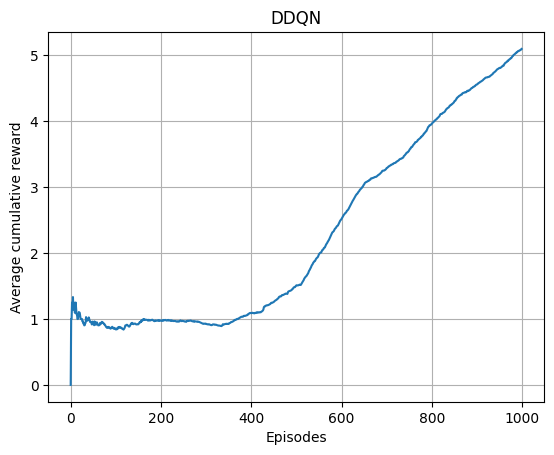

In [18]:
plt.title('DDQN')
plt.grid()
plt.ylabel('Average cumulative reward')
plt.xlabel('Episodes')
plt.plot(np.cumsum(return_arr) / np.arange(1, len(return_arr)+1))

In [16]:
torch.save(
    dict(model=agent.Q.state_dict()),
    f'DDQNAgent-final.chkpt',
)

# Test

In [21]:
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0, render_mode='human')

In [22]:
##
### Play and display in pygame window.

episodes = 1
for e in range(episodes):
    Return = 0
    s, _ = env.reset()
    s = env.step(1)
    s = s[0]
    s = agent.preprocess(s)
    s = torch.stack([s, s, s, s])
    steps = 10_000
    for i in range(steps):
        a = agent.act(s)
        (s_, r, d, t, _) = env.step(a)
        s_ = agent.preprocess(s_)
        s_ = torch.stack([*s[1:], s_])
        s = s_
        Return += r
        
        if d or t:
            print('done d')
            break
            
    if (e + 1 ) % 10 == 0:
        print(f"Episode: {e+1}, Return: {Return}")
print(Return)

done d
32.0


# Save video

In [22]:
##
## Play and save the game as video

rec_env = gym.wrappers.RecordVideo(env, './ddqn')
rec_env.metadata['render_fps'] = 24

episodes = 1
for e in range(episodes):
    Return = 0
    s, _ = rec_env.reset()
    s = rec_env.step(1)
    s = s[0]
    s = agent.preprocess(s)
    s = torch.stack([s, s, s, s])
    steps = 10_000
    for i in range(steps):
        a = agent.act(s)
        (s_, r, d, t, _) = rec_env.step(a)
        s_ = agent.preprocess(s_)
        s_ = torch.stack([*s[1:], s_])
        s = s_
        Return += r
        
        if d or t:
            print('done d')
            break
            
    if (e + 1 ) % 10 == 0:
        print(f"Episode: {e+1}, Return: {Return}")

/home/default/miniconda3/envs/torch/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /home/default/Jupyter_notebook/akash/ddqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/default/Jupyter_notebook/akash/ddqn/rl-video-episode-0.mp4.
Moviepy - Writing video /home/default/Jupyter_notebook/akash/ddqn/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/default/Jupyter_notebook/akash/ddqn/rl-video-episode-0.mp4
done d


In [23]:
Return

16.0

In [24]:
rec_env.close()

In [25]:
torch.save(
    dict(model=agent.Q.state_dict(), exploration_rate=agent.e, memory=agent.memory, return_arr=return_arr),
    f'DDQNAgent-simple-final.chkpt',
)